Imports

In [1]:
from Dataset import processData
# from Train import train
import os
from Model import KGLinkPredictor
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score

Process Data and Save for Later

In [2]:
batch_size = 16384
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data, pretrain_loader, train_loader, val_loader, test_loader, kg = processData('data',batch_size,device=device)

# torch.save(data, 'data/data.pt')
# torch.save(pretrain_loader, 'data/ptloader.pt')
# torch.save(train_loader, 'data/trloader.pt')
# torch.save(val_loader, 'data/vloader.pt')
# torch.save(test_loader, 'data/teloader.pt')
# torch.save(kg, 'data/kg.pt')

Loading data from path: data/


IsADirectoryError: [Errno 21] Is a directory: 'data/'

In [2]:
data = torch.load('../processed_data/data.pt')
pretrain_loader = torch.load('../processed_data/ptloader.pt')
train_loader = torch.load('../processed_data/trloader.pt')
val_loader = torch.load('../processed_data/vloader.pt')
test_loader = torch.load('../processed_data/teloader.pt')
kg = torch.load('../processed_data/kg.pt')

Declare and Train Model (ONLY IF MODEL HAS NOT BEEN TRAINED AND SAVED YET)

In [32]:
len(test) / 16384

500.3685302734375

In [8]:
num_heads = 2
hidden_dim = 128
embedding_dim = 768
num_layers = 4
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = KGLinkPredictor(embedding_dim,hidden_dim,num_heads,num_layers,data,device).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
data = data.to(device)

# # print('Pretraining...')
# # pre_train(ptrain_loader, model, optimizer, device)

# model.Decoder.reset_parameters()

# print('Fine-tuning...')
# train(train_loader, val_loader, model, optimizer, device, 50)

In [15]:
batch = next(iter(train_loader))

In [18]:
batch.T[0]

tensor([88455, 27901, 34213,  ..., 29717, 38952, 39165], device='cuda:0')

Save Model

In [4]:
torch.save(model.state_dict(), 'models/TestModel.pt')

Load Model (CURRENTLY NONFUNCTIONAL)

In [5]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model2 = KGLinkPredictor(embedding_dim,hidden_dim,data,device).to(device)
model2.load_state_dict(torch.load(r'models/TestModel.pt'))

<All keys matched successfully>

Evaluate

In [16]:
indication_true = np.array([])
indication_pred = np.array([])

contraindication_true = np.array([])
contraindication_pred = np.array([])

for batch in fval_loader:
    
    contraindication = batch[batch[:,1] == 2]
    indication = batch[batch[:,1] == 3]
    
    contra_head,contra_rel,contra_tail = contraindication[:,0],contraindication[:,1],contraindication[:,2]
    contra_head,contra_rel,contra_tail = contra_head.to(device),contra_rel.to(device),contra_tail.to(device)
    
    indi_head,indi_rel,indi_tail = indication[:,0],indication[:,1],indication[:,2]
    indi_head,indi_rel,indi_tail = indi_head.to(device),indi_rel.to(device),indi_tail.to(device)
    
    contraindication_true = np.append(contraindication_true,len(contraindication)*[1])
    contraindication_pred = np.append(contraindication_pred,torch.sigmoid(model.Decoder(contra_head,contra_rel,contra_tail)).detach().cpu().numpy().flatten())
    contraindication_true = np.append(contraindication_true,len(contraindication)*[0])
    contraindication_pred = np.append(contraindication_pred,torch.sigmoid(model.Decoder(*model.Decoder.random_sample(contra_head, contra_rel, contra_tail), loss_tag=False)).detach().cpu().numpy().flatten())
    
    indication_true = np.append(indication_true,len(indication)*[1])
    indication_pred = np.append(indication_pred,torch.sigmoid(model.Decoder(indi_head,indi_rel,indi_tail)).detach().cpu().numpy().flatten())
    indication_true = np.append(indication_true,len(indication)*[0])
    indication_pred = np.append(indication_pred,torch.sigmoid(model.Decoder(*model.Decoder.random_sample(indi_head, indi_rel, indi_tail), loss_tag=False)).detach().cpu().numpy().flatten())

Plot ROC curves

Indication AUC: 0.9619644245424203
Contraindication AUC: 0.9749279440030745


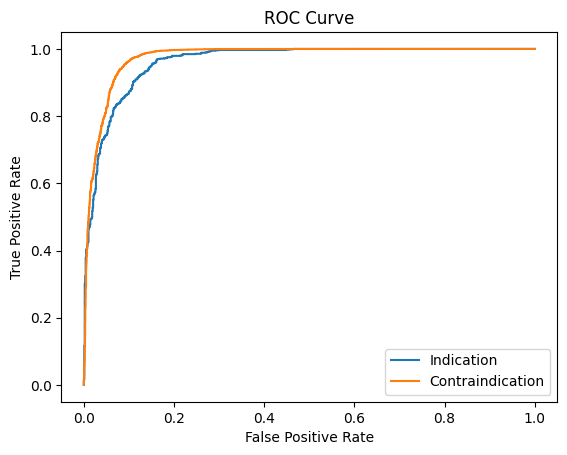

In [17]:
def plot_roc_curve(indication_true, indication_pred, contraindication_true, contraindication_pred):
    """
    plots the roc curve based of the probabilities
    """

    i_fpr, i_tpr, thresholds = roc_curve(indication_true, indication_pred)
    c_fpr, c_tpr, thresholds = roc_curve(contraindication_true, contraindication_pred)
    plt.plot(i_fpr, i_tpr)
    plt.plot(c_fpr, c_tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(['Indication','Contraindication'])

plot_roc_curve(indication_true, indication_pred, contraindication_true, contraindication_pred)

print('Indication AUC:',roc_auc_score(indication_true, indication_pred))
print('Contraindication AUC:',roc_auc_score(contraindication_true, contraindication_pred))

Find optimal threshold for f1 score

In [18]:
contraindication_thresholds = []
indication_thresholds = []
for thresh in range(-45,50,1):
    thresh = thresh/100
    contraindication_pred_mod = np.round(contraindication_pred-thresh)
    indication_pred_mod = np.round(indication_pred-thresh)
    
    contraindication_thresholds.append(f1_score(contraindication_true, contraindication_pred_mod))
    indication_thresholds.append(f1_score(indication_true, indication_pred_mod))

contraindication_threshold = round((contraindication_thresholds.index(max(contraindication_thresholds)) - 45) / 100,2)
indication_threshold = round((indication_thresholds.index(max(indication_thresholds)) - 45) / 100,2)

Show confusion matrices

In [19]:
print(f'Indication: \n{confusion_matrix(indication_true, np.round(indication_pred-indication_threshold))}\n')
print(f'Contraindication: \n{confusion_matrix(contraindication_true, np.round(contraindication_pred-contraindication_threshold))}')

Indication: 
[[812 159]
 [ 29 942]]

Contraindication: 
[[3057  366]
 [  98 3325]]


Apply to our diseases

In [20]:
our_diseases = ['iEndos']

In [21]:
indication_predictions  = np.zeros((len(our_diseases),data['drug'].num_nodes))
contraindication_predictions  = np.zeros((len(our_diseases),data['drug'].num_nodes))

for i,disease in enumerate(our_diseases):
    x_index = kg[(kg['x_type']=='disease') & (kg['x_name']==disease)]['x_index'].unique()[0]
    
    contraindication = torch.ones(data['drug'].num_nodes,dtype=torch.long)*4
    indication = torch.ones(data['drug'].num_nodes,dtype=torch.long)*5
    drug = torch.arange(0,data['drug'].num_nodes,dtype=torch.long)
    query_disease = torch.ones(data['drug'].num_nodes,dtype=torch.long)*x_index
    
    indication_predictions[i] = torch.sigmoid(model.Decoder(query_disease,indication,drug)).detach().cpu().numpy().flatten()
    contraindication_predictions[i] = torch.sigmoid(model.Decoder(query_disease,contraindication,drug)).detach().cpu().numpy().flatten()

No drug in our network reaches a viable indication or contraindication threshold

In [22]:
for i,disease in enumerate(our_diseases):
    print(disease)
    print(f'Max Indication: {round(max(indication_predictions[i]),2)} | Threshold: {round(0.5 + indication_threshold,2)}')
    print(f'Max Contraindication: {round(max(contraindication_predictions[i]),2)} | Threshold: {round(0.5 + contraindication_threshold,2)}\n')

iEndos
Max Indication: 0.51 | Threshold: 0.77
Max Contraindication: 0.65 | Threshold: 0.83



Save scores for later use

In [13]:
torch.save(indication_predictions, 'indication_predictions++.pt')
torch.save(contraindication_predictions, 'contraindication_predictions++.pt')

In [ ]:
indication_predictions = torch.load('indication_predictions++.pt')
contraindication_predictions = torch.load('contraindication_predictions++.pt')

In [22]:
contraindication_predictions.shape

(1, 7957)

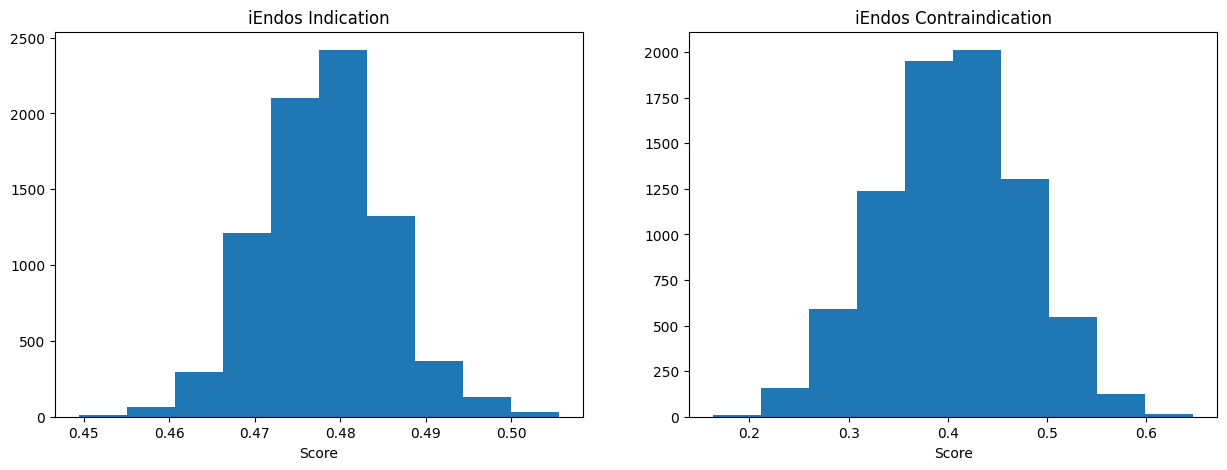

In [23]:
diseases = ['iEndos']

ax,fig = plt.subplots(len(diseases),2,figsize=(15,5))
for i,disease in enumerate(contraindication_predictions):
    
    fig[0].hist(indication_predictions[i],bins=10)
    fig[0].set_title(f'{diseases[i]} Indication')
    fig[0].set_xlabel('Score')
    
    fig[1].hist(contraindication_predictions[i],bins=10)
    fig[1].set_title(f'{diseases[i]} Contraindication')
    fig[1].set_xlabel('Score')
        
plt.show()

In [24]:
drugs = kg[kg['x_type']=='drug']['x_name'].unique()
drugs[torch.topk(torch.Tensor(indication_predictions[0]),10).indices]

array(['Tamsulosin', 'Dodecyldimethylamine N_oxide', 'Metolazone',
       'Atropine', 'Nipecotic acid', 'Lumateperone',
       'Aminomethylcyclohexane', 'Bemiparin', 'MK_1775', 'Pralnacasan'],
      dtype=object)